<a href="https://colab.research.google.com/github/iu5git/Deep-learning/blob/main/notebooks/tree_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа



# Задание

Обучите модель нейронной сети для классификации пород деревьев, используя файлы облака точек.



# Задания для самостоятельной работы

1. Укажите файл по вашему варианту и измените список классов, которые относятся к вашему варианту. Обучите модель
2. Измените гиперпараметры обучения для улучшения модели: количество эпох, размер батча, скорость обучения
3. Укажите, какие действия помогли улучшить метрики ваших моделей и объясните почему.

# Контрольные вопросы для защиты

1. Архитектура PointNet
2. Что такое плотное облако точек? Форматы представления

## Теория

Облако точек - это самый простой способ представления различных объектов в виде неупорядоченного набора точек в трехмерной плоскости. Такие данные можно получить с помощью сканирования предметов или их структуры с помощью 3D-датчиков, например LiDAR. Качественные облака точек с высокой точностью измерения позволяют представить цифровую версию реального мира.

<figure>
<center>
<img src='https://www.codeproject.com/KB/openGL/839389/bunny_points.PNG' />
<figcaption>Стэндфордский кролик</figcaption></center>
</figure>

Как правило, при глубоком обучении трехмерного облака точек необходимо решить две задачи: классификацию и сегментацию.
Основная проблема работы с облаком точек заключается в том, что типичная сверточная архитектура требует упорядоченный формат входных данных (например, изображение). Поскольку облако точек не является таким, общепринятые подходы заключаются в преобразовании данных в обычную 3D-воксельную сетку или проекцию.

В данной лабораторной работе используется архитектура PointNet. Эта модель использует неупорядоченные облака точек и может выполнять классификацию и сегментацию объектов, а также семантический анализ сцены.

<figure>
<center>
<img src='http://stanford.edu/~rqi/pointnet/images/teaser.jpg' />
<figcaption>Применение PointNet</figcaption></center>
</figure>

В сети есть 3 ключевых модуля: слой Max Pooling, принимающий n векторов входных данных и выводящий новый вектор, две сети трансформации с многослойным персептроном (MLP) с размерами (64,64) и (64,128,1024) и две сети для предсказания с обученной матрицей преобразования T-Net.

PointNet изучает характеристики индивидуальной точки с помощью MLP и объединяет все их характеристики с помощью симметричной функции для выполнения классификации объектов и их сегментации на части. 

<figure>
<center>
<img src='http://stanford.edu/~rqi/pointnet/images/pointnet.jpg' />
<figcaption>Архитектура PointNet</figcaption></center>
</figure>


## Импорт библиотек

In [ ]:
!apt install subversion

In [1]:
import os
import glob
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import itertools

tf.random.set_seed(42)

## Загрузка набора данных

Для выполнения лабораторной работы необходимо скачать файл формата h5. Поскольку каждая точка одного облака точек содержит информацию о 3 различных координатах, данный формат удобен для хранения и работы с таким большим объемом данных.

Файл выбирается следующим образом:

v1 - нечетный вариант, v2 - четный вариант

In [ ]:
!svn checkout https://github.com/iu5git/Deep-learning/trunk/datasets/lidar

A    lidar/v1.h5
A    lidar/v2.h5
Checked out revision 119.


In [4]:
DATA_DIR = ""

In [8]:
h5f = h5py.File(os.path.join(DATA_DIR, "v1.h5"),'r') # файл по вашему варианту
X = h5f.get('dataset_X')[:]
Y = h5f.get('dataset_Y').asstr()[:]
h5f.close()

In [9]:
NUM_POINTS = 4096
BATCH_SIZE = 64

# Укажите классы по варианту из вашего файла
CLASSES = {
    0:'Рябина', 
    1:'Ель', 
    2:'Сосна', 
    3:'Дуб',
    4:'Береза'
}

In [10]:
Y = np.array([list(CLASSES.values()).index(y) for y in Y])
indexes = []
[indexes.append(y) for y in list(Y) if y not in indexes]
indexes.sort()
CLASS_MAP = {i: CLASSES[k] for (k, i) in (zip(indexes, range(len(indexes))))}

#кол-во классов по вашему варианту
NUM_CLASSES = len(CLASS_MAP)

for (k, i) in (zip(indexes, range(len(indexes)))):
  Y[Y == k] = i

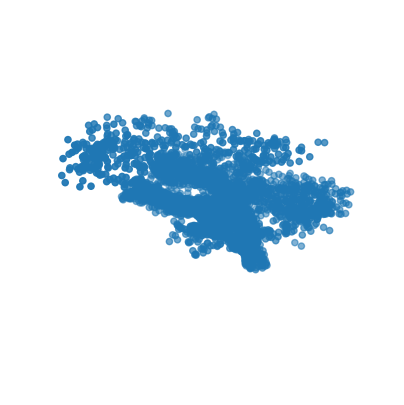

In [11]:
points = X[50]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

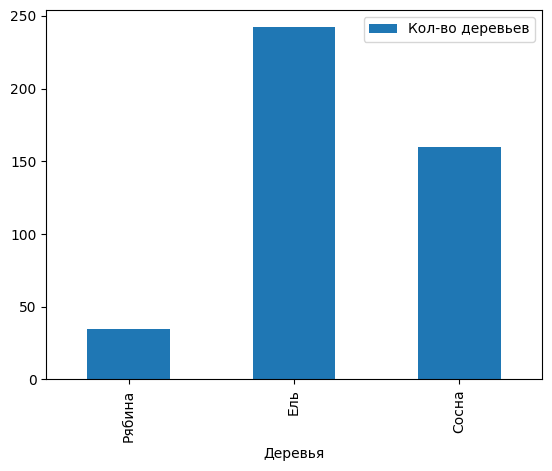

In [12]:
data = {'Кол-во деревьев': list(pd.value_counts(Y).sort_index()),
        'Деревья': list(CLASS_MAP.values())}
df = pd.DataFrame(data).set_index('Деревья')
ax = df.plot.bar()

## Разбиение выборки на тренировочную и тестовую

In [15]:
skf = StratifiedKFold(n_splits=5).split(X, Y)

for train_index, test_index in skf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

X_augment = []
y_augment = []

for i in range(4):
    point_select = []
    for x in X_train:
        idx = np.random.choice(X_train.shape[0], size=NUM_POINTS, replace=True)
        point_select.append(x[idx])
    point_select = np.array(point_select)        
    point_select = point_select + np.random.normal(0, 0.005, point_select.shape)
    X_augment.append(point_select)
    y_augment.append(y_train)

X_augment = np.array(X_augment)
y_augment = np.array(y_augment)
X_augment = np.reshape(X_augment,(X_augment.shape[0] * X_augment.shape[1], NUM_POINTS, 3))
y_augment = np.reshape(y_augment,(-1))

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_augment, y_augment))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(len(X_augment)).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(X_test)).batch(BATCH_SIZE)

## Построение модели

Каждый сверточный и полносвязный слой (не включая конечных слоев) состоит из Convolution / Dense -> Batch Normalization -> ReLU Activation.

In [17]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

PointNet состоит из двух основных компонентов: основная сеть MLP (многослойный перцептрон) и трансформаторная сеть T-net.

In [18]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

Определим общую функцию для построения слоев T-net.

In [19]:
def tnet(inputs, num_features):

    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [20]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4096, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 4096, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 4096, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 4096, 32)     0           ['batch_normalization[0][0

## Обучение модели

In [21]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
22/22 [==============================] - 147s 6s/step - loss: 5.0656 - sparse_categorical_accuracy: 0.3943 - val_loss: 4.1525 - val_sparse_categorical_accuracy: 0.3793
Epoch 2/10
22/22 [==============================] - 138s 6s/step - loss: 4.1686 - sparse_categorical_accuracy: 0.6014 - val_loss: 3.5909 - val_sparse_categorical_accuracy: 0.7126
Epoch 3/10
11/22 [==============>...............] - ETA: 1:07 - loss: 3.7923 - sparse_categorical_accuracy: 0.6577

KeyboardInterrupt: 

## Визуализация результатов

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

fig = plt.figure(figsize=(15, 15))
for i in range(8):
    ax = fig.add_subplot(4, 2, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
data = test_dataset.take(1)
points, labels = list(data)[0]
points = points[:, ...]
labels = labels[:, ...]

preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

cm = confusion_matrix(y_true=labels, y_pred=preds)

In [ ]:
plot_confusion_matrix(cm=cm, classes=CLASS_MAP.values(), title='Confusion Matrix')